### Processing demo: ASTER DEM refinement by using altimetry data.
### TODO: 
**For the ASTER DEM refinement by using icesat-2, the ASTER DEM should be replaced by the dem which is generated at the period of 2018-2022.**



In [6]:
import h5py
import xdem
import numpy as np
import statistics
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.transform_xy import geo2imagexy
from matplotlib.colors import LinearSegmentedColormap


In [3]:
### --- remove icesat points which 1) outside the given image extent; 2) locate in the water region; 
#       the masked icesat point is with the coordinates system.
def icesat_mask(lon, lat, h, mask_img, mask_img_geotrans):
    row, col = geo2imagexy(x=lon, y=lat, gdal_trans=mask_img_geotrans, integer=False)
    idx_in = np.where((row<mask_img.shape[0]) & (col<mask_img.shape[1]))[0]
    row_, col_, h_ = row[idx_in], col[idx_in], h[idx_in]    
    mask_icesat = mask_img[row_.astype('int'), col_.astype('int')]
    valid_idx = np.where((mask_icesat==1))[0]
    row_, col_, h_ = row_[valid_idx], col_[valid_idx], h_[valid_idx]
    return row_, col_, h_
  
### dem correction with altimetry data.
def dem_correction(dem, row_altimetry, col_altimetry, h_altimetry, size_local=100, overlay=30):
  ## -- 1. global correction 
  ### assign median dif value to global region.
  h_dif = h_altimetry - dem[np.floor(row_altimetry).astype('int'), \
                                              np.floor(col_altimetry).astype('int')]
  mean_global = statistics.mean(h_dif)
  var_global = statistics.variance(h_dif.astype('float64'))
  h_dif_map = np.zeros_like(dem)
  h_dif_map[:,:] = mean_global
  ## -- 2. local correction 
  n_row_local = dem.shape[0]/(size_local-overlay)
  n_col_local = dem.shape[1]/(size_local-overlay)
  n_regions=0
  for i_row_local in range(np.ceil(n_row_local).astype('int')):
    for i_col_local in range(np.ceil(n_col_local).astype('int')):
      n_regions+=1
      ## local pixels corresponding to the global image. 
      i_row_global_0, i_col_global_0 = i_row_local*(size_local-overlay), i_col_local*(size_local-overlay)
      i_row_global_1, i_col_global_1 = i_row_global_0+size_local, i_col_global_0+size_local
      ## select icesat data corresponding to local region, and convert the index to local coordinate
      idx = np.where((row_altimetry>i_row_global_0) & (row_altimetry<i_row_global_0+size_local) & \
                                (col_altimetry>i_col_global_0) & (col_altimetry<i_col_global_0+size_local))
      row_altimetry_local = row_altimetry[idx]-i_row_global_0
      col_altimetry_local = col_altimetry[idx]-i_col_global_0
      h_altimetry_local = h_altimetry[idx]
      ## calculate the dem difference of the local region. 
      if h_altimetry_local.shape[0] > 20:
        h_dif_local = h_altimetry_local - dem[row_altimetry[idx].astype('int'), \
                                                              col_altimetry[idx].astype('int')]
        mean_local = statistics.mean(h_dif_local)
        var_local = statistics.variance(h_dif_local.astype('float64'))
        if var_local < var_global:
          h_dif_map[i_row_global_0:i_row_global_0+size_local, i_col_global_0:i_col_global_0+size_local] = mean_local
  print('number of local regions:',n_regions)
  return h_dif_map

In [4]:
path_dem_aligned = 'data/aster-stereo/2009-36-78/dem_coreg.tif' # dem data waiting for improved through interpolation
path_atl06='data/icesat/atl06-readout/tile-36-78/ATL06_2020.h5'
path_glah14='data/icesat/glah14-readout/tile-36-78/GLAH14_2009_subs.H5'
path_water_jrc = 'data/water_jrc/water_jrc_36_78.tif'   # jrc water map for water mask
path_dem_correct = 'data/aster-stereo/2009-36-78/dem_correct.tif'
tile_lat, tile_lon = 36,78



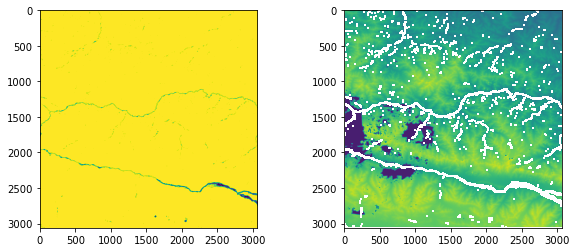

In [5]:
### -- 2.water mask
dem = xdem.DEM(path_dem_aligned)         # 
water_jrc = xdem.DEM(path_water_jrc).reproject(dem)
mask_wat = np.where(water_jrc.data[0]==0, 1, 0)    # non-water region
dem_masked=np.copy(dem.data[0]); dem_masked[mask_wat ==0] = np.nan
# dem_masked[np.isnan(dem_masked)] = 0
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(mask_wat)
plt.subplot(1,2,2); plt.imshow(dem_masked)


In [6]:
### Read one-tile/one-year ATL06 data
with h5py.File(path_atl06, 'r') as f_atl06_tile:
    atl06_lat_tile   = f_atl06_tile['h_lat'][:]
    atl06_lon_tile   = f_atl06_tile['h_lon'][:]
    atl06_h_tile = f_atl06_tile['h_li'][:]
    atl06_t_tile = f_atl06_tile['t_dyr'][:]
    print(f_atl06_tile.keys())

### Read one-year/full-region glas14/icesat data
with h5py.File(path_glah14, 'r') as f_glah14_tile:
    glah14_lat_tile = f_glah14_tile['h_lat'][:]
    glah14_lon_tile = f_glah14_tile['h_lon'][:]
    glah14_h_tile = f_glah14_tile['h_cor'][:]
    glah14_t_tile = f_glah14_tile['t_dyr'][:]
    print(f_glah14_tile.keys())


<KeysViewHDF5 ['beam_type', 'cycle', 'h_lat', 'h_li', 'h_lon', 'orbit_type', 'rgt', 'spot', 't_dyr']>
<KeysViewHDF5 ['h_cor', 'h_lat', 'h_lon', 'h_orbit', 'h_track', 't_dyr']>


In [7]:
# lat_altimetry, lon_altimetry, h_altimetry = atl06_lat_tile, atl06_lon_tile, atl06_h_tile
lat_altimetry, lon_altimetry, h_altimetry = glah14_lat_tile, glah14_lon_tile, glah14_h_tile


In [8]:
_, dem_info = readTiff(path_dem_aligned)
row_altimetry_mask, col_altimetry_mask, h_altimetry_mask = icesat_mask(lon_altimetry, \
                                    lat_altimetry, h_altimetry, mask_wat, dem_info['geotrans'])
print(lon_altimetry.shape, row_altimetry_mask.shape)


(113,) (107,)


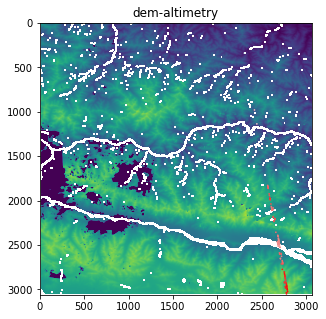

In [9]:
## visualize dem-altimetry
cmap = LinearSegmentedColormap.from_list('linear color', ['LightCyan', 'Red'])
plt.figure(figsize=(5, 5))
plt.imshow(dem_masked, vmin=2000, vmax=7000); plt.title('dem-altimetry')
plt.scatter(x=np.floor(col_altimetry_mask), y=np.floor(row_altimetry_mask), c=h_altimetry_mask, s=0.5, cmap=cmap)


In [10]:
### 1) filter out the outlier data (|dif| > 100 m) and the value out the range of 5%~95% 
### 2) statistic before interpolation
h_dif = h_altimetry_mask - dem_masked[np.floor(row_altimetry_mask).astype('int'), \
                                                        np.floor(col_altimetry_mask).astype('int')]

### -- remove outlier values: 1. remove the points of |h_dif| < 100; 
###                           2. remove the value out the range of 5%~95%
idx_valid = np.where((h_dif<100) & (h_dif > -100))      ## remove the points of |h_dif| < 100 
row_altimetry_valid, col_altimetry_valid, h_altimetry_valid, h_dif_valid = \
            row_altimetry_mask[idx_valid], col_altimetry_mask[idx_valid], h_altimetry_mask[idx_valid], h_dif[idx_valid]
idx_valid =  np.where((h_dif_valid>np.nanpercentile(h_dif_valid, 5)) & (h_dif_valid<np.nanpercentile(h_dif_valid, 95)))
row_altimetry_valid, col_altimetry_valid, h_altimetry_valid, h_dif_valid = \
            row_altimetry_valid[idx_valid], col_altimetry_valid[idx_valid], h_altimetry_valid[idx_valid], h_dif_valid[idx_valid]

global_mean = statistics.mean(h_dif_valid)
global_var = statistics.variance(h_dif_valid.astype('float64'))
print('global dem dif mean:', global_mean)
print('global dem dif variance:', global_var)



global dem dif mean: 7.331724
global dem dif variance: 137.57174391448916


Text(0.5, 1.0, 'Difference points distribution.')

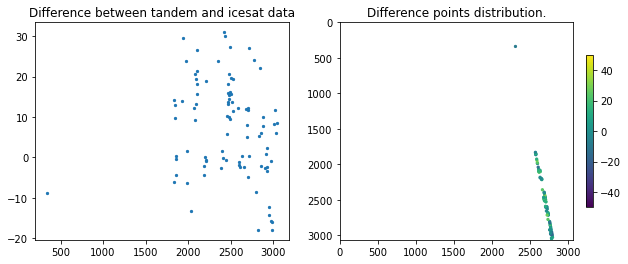

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.scatter(row_altimetry_valid, h_dif_valid,s=5)
# plt.scatter(row_altimetry_valid[::600], h_dif_valid[::600],s=5)  ## for icesat-2 data
plt.title('Difference between tandem and icesat data')
plt.subplot(1,2,2)
cax=plt.scatter(x=col_altimetry_valid, y=row_altimetry_valid,\
                              c=h_dif_valid, s=5, vmax=50, vmin=-50)     ## for icesat-1 data
# cax=plt.scatter(x=col_altimetry_valid[::600], y=row_altimetry_valid[::600],\
#                           c=h_dif_valid[::600], s=5, vmax=50, vmin=-50)   ## for icesat-2 data
plt.xlim([0, dem_masked.shape[1]]);  plt.ylim([dem_masked.shape[0], 0])
cbar=plt.colorbar(cax,fraction=0.03) 
plt.title('Difference points distribution.')


### **Crop image into multiple local regions**


Text(0.5, 1.0, 'dem-altimetry')

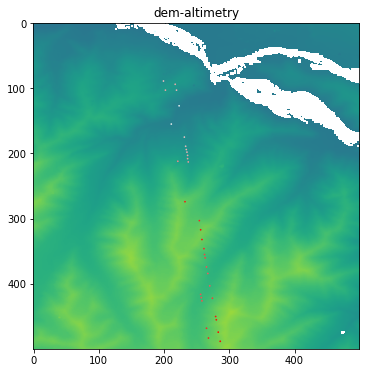

In [12]:
## check the local region and the related icesat data.
i_row_global_0, i_col_global_0, size_local = 2500, 2500, 500 ## the up-left corner of the local region.
# i_row_global_0, i_col_global_0, size_local = 2400, 2600, 100  ## for icesat-2 data

idx = np.where((row_altimetry_valid>i_row_global_0) & (row_altimetry_valid<i_row_global_0+size_local) & \
                          (col_altimetry_valid>i_col_global_0) & (col_altimetry_valid<i_col_global_0+size_local))

row_altimetry_local = row_altimetry_valid[idx]-i_row_global_0
col_altimetry_local = col_altimetry_valid[idx]-i_col_global_0
h_altimetry_local = h_altimetry_valid[idx]
plt.figure(figsize=(6, 6))
plt.imshow(dem_masked[i_row_global_0:i_row_global_0+size_local, \
                            i_col_global_0:i_col_global_0+size_local], vmin=2000, vmax=7000);
plt.scatter(x=np.floor(col_altimetry_local), y=np.floor(row_altimetry_local), c=h_altimetry_local, s=0.5, cmap=cmap)
plt.title('dem-altimetry')


### DEM correction

In [13]:
h_dif_map = dem_correction(dem=dem_masked, row_altimetry=row_altimetry_valid, \
                col_altimetry=col_altimetry_valid, h_altimetry=h_altimetry_valid, size_local=200, overlay=100)
h_dif_map.shape
dem_masked_correct = dem_masked + h_dif_map  ## dem correction
writeTiff(im_data=dem_masked_correct, im_geotrans=dem_info['geotrans'], \
                                   im_geosrs=dem_info['geosrs'], path_out=path_dem_correct)


number of local regions: 961


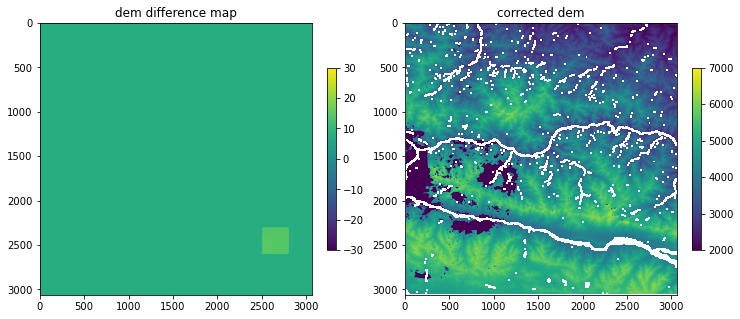

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
cax = plt.imshow(h_dif_map, vmax=30, vmin=-30)
plt.title('dem difference map')
plt.colorbar(cax,fraction=0.03)
plt.subplot(1,2,2)
cax = plt.imshow(dem_masked_correct, vmax=7000, vmin=2000)
plt.title('corrected dem')
plt.colorbar(cax, fraction=0.03)


### dem vs. corrected dem

In [15]:
### 1) filter out the outlier data and 2) statistic before interpolation 
h_dif_correct = h_altimetry_valid - dem_masked_correct[np.floor(row_altimetry_valid).astype('int'), \
                                                      np.floor(col_altimetry_valid).astype('int')]
global_median_cor = statistics.median(h_dif_correct)
global_var_cor = statistics.variance(h_dif_correct.astype('float64'))
print('global dem dif median:', global_mean)
print('global dem dif variance:', global_var)
print('corrected global dem dif median:', global_median_cor)
print('corrected global dem dif variance:', global_var_cor)


global dem dif median: 7.331724
global dem dif variance: 137.57174391448916
corrected global dem dif median: -1.2504883
corrected global dem dif variance: 121.4130832684157
